In [1]:
import pybaseball as pyb
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import seaborn as sns
from sklearn.utils import resample 
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing 
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import plot_confusion_matrix 
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# Pitch Value

In [2]:
mlb_21=pd.read_csv('mlb_21.csv').drop('Unnamed: 0', axis=1)
mlb_19=pd.read_csv('mlb_19.csv').drop('Unnamed: 0', axis=1)

In [3]:
concat_data = pd.concat([mlb_21, mlb_19])

In [4]:
mlb_21['pitch_name'].unique()

array(['4-Seam Fastball', 'Slider', 'Curveball', 'Sinker', 'Split-Finger',
       'Cutter', 'Changeup', 'Knuckle Curve', nan, 'Fastball',
       'Knuckleball', 'Eephus', 'Screwball'], dtype=object)

In [5]:
data_21 = concat_data[['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'release_pos_y', 'player_name', 'batter', 'pitcher', 'events', 'description', 'zone',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y', 'launch_speed', 'launch_angle', 'release_spin_rate', 'release_extension', 'game_pk',
       'woba_value', 'launch_speed_angle', 'at_bat_number', 'pitch_number', 'pitch_name', 'home_score', 'away_score', 'post_away_score', 'post_home_score',
       'bat_score', 'post_bat_score', 'fld_score', 'delta_home_win_exp', 'delta_run_exp']]

data_21['1b'] = np.where(data_21['on_1b'].notnull(), 1, 0)
data_21['2b'] = np.where(data_21['on_2b'].notnull(), 1, 0)
data_21['3b'] = np.where(data_21['on_3b'].notnull(), 1, 0)
data_21 = data_21.sort_values(by=['game_pk', 'at_bat_number', 'pitch_number'])
data_21['start_state'] = data_21['1b'].astype('str') + data_21['2b'].astype('str') + data_21['3b'].astype('str') + ' ' + data_21['outs_when_up'].astype('str')
data_21['next_state'] = data_21['start_state'].shift(-1)
data_21['next_topbot'] = data_21['inning_topbot'].shift(-1)
data_21['next_game_pk'] = data_21['game_pk'].shift(-1)
data_21['next_state'] = np.where((data_21['inning_topbot']!=data_21['next_topbot'])|
                                 (data_21['next_game_pk']!=data_21['game_pk'])|
                                 (data_21['next_state'].isnull()), '000 3', data_21['next_state'])

data_21['scoring'] = data_21['post_bat_score'] - data_21['bat_score']
score = data_21.groupby(['game_pk', 'inning', 'inning_topbot'])['bat_score'].max().reset_index().rename(columns={'bat_score': 'inning_score'})
data_21 = pd.merge(data_21, score, on=['game_pk', 'inning', 'inning_topbot'])

In [6]:
events = data_21[data_21['events'].notnull()]
events['future_run'] = events['inning_score'] - events['bat_score']
re = events.groupby('start_state')['future_run'].mean().reset_index().rename(columns={'future_run': 're'})
re_0003 = pd.DataFrame([['000 3', 0]], columns=['start_state', 're'])
re = re.append(re_0003)
data_21 = pd.merge(data_21, re, on=['start_state'])
events = pd.merge(events, re, on=['start_state'])

In [7]:
next_re = re.copy().rename(columns={'start_state': 'next_state', 're': 'next_re'})
data_21 = pd.merge(data_21, next_re, on=['next_state'])
data_21 = data_21.sort_values(by=['game_pk', 'at_bat_number', 'pitch_number'])
events = pd.merge(events, next_re, on=['next_state'])

In [8]:
events['run_value'] = events['next_re'].astype('float') - events['re'].astype('float') + events['post_bat_score'].astype('float') - events['bat_score'].astype('float')
at_bat_rv = events[['game_pk', 'at_bat_number', 'run_value']]
data_21 = pd.merge(data_21, at_bat_rv, on=['game_pk', 'at_bat_number'])
event_rv = data_21.groupby('events')['run_value'].mean().reset_index().sort_values(by='run_value', ascending=False).rename(columns={'run_value': 'event_rv'})

In [9]:
data_21 = pd.merge(data_21, event_rv, on='events', how='left')
data_21['count'] = data_21['balls'].astype('str')+'-'+data_21['strikes'].astype('str')
data_21 = data_21[data_21['balls']!=4]
rv_by_count = data_21.groupby(['count'])['run_value'].mean().reset_index().rename(columns={'run_value': 'count_rv'})

In [10]:
rv_by_count

,count,count_rv
0,0-0,-0.001896
1,0-1,-0.045958
2,0-2,-0.105163
3,1-0,0.035825
4,1-1,-0.015437
5,1-2,-0.079894
6,2-0,0.099206
7,2-1,0.034661
8,2-2,-0.037455
9,3-0,0.202600


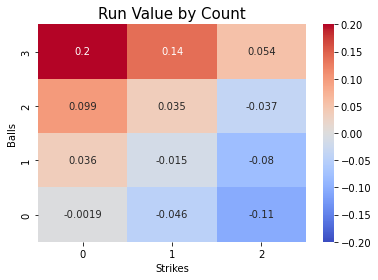

In [11]:
table1 = pd.DataFrame(np.array([rv_by_count['count_rv'][0:3], rv_by_count['count_rv'][3:6], rv_by_count['count_rv'][6:9], rv_by_count['count_rv'][9:12]]),
            columns=['0','1','2'], index=['0','1','2','3'], dtype='float')

sns.heatmap(table1.iloc[::-1], annot=True, cmap='coolwarm', vmin=-0.2, vmax=0.2)
plt.title("Run Value by Count", size=15)
plt.xlabel('Strikes')
plt.ylabel('Balls')
plt.show()

In [12]:
data_21 = pd.merge(data_21, rv_by_count, on='count')
data_21 = data_21.sort_values(by=['game_pk', 'at_bat_number', 'pitch_number'])
data_21['next_count_rv'] = data_21['count_rv'].shift(-1)
data_21['next_count_rv'] = np.where(data_21['events'].isnull(), data_21['next_count_rv'], data_21['event_rv'])

data_21['pitch_value'] = data_21['next_count_rv'] - data_21['count_rv']


In [13]:
df = data_21.copy()

# Visualization

In [14]:
pv = data_21[['game_year', 'player_name', 'pitch_name', 'p_throws', 'stand','count', 'plate_x', 'plate_z', 'pitch_value']].dropna()
pv['adj_x'] = round(pv['plate_x']* 4) / 4
pv['adj_z'] = round(pv['plate_z']* 4) / 4

In [15]:
ff = pv[pv['pitch_name']=='4-Seam Fastball']
ff_pv = ff.groupby(['p_throws', 'stand', 'count', 'adj_x', 'adj_z'])['pitch_value'].mean().reset_index()

sl = pv[pv['pitch_name']=='Slider']
sl_pv = sl.groupby(['p_throws', 'stand', 'count', 'adj_x', 'adj_z'])['pitch_value'].mean().reset_index()

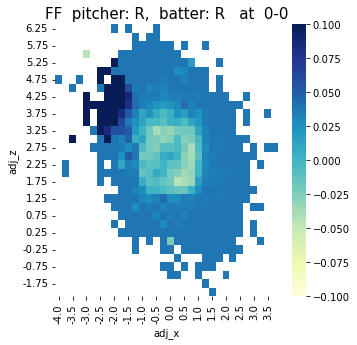

In [16]:
rr = ff_pv[(ff_pv['p_throws']=='R')&(ff_pv['stand']=='R')]
count00 =rr[rr['count']=='0-0']
test_pivot = count00.pivot_table(index='adj_z', columns='adj_x', values='pitch_value')
plt.figure(figsize=(5,5))
plt.title('FF  pitcher: R,  batter: R   at  0-0', size=15)
sns.heatmap(data=test_pivot.iloc[::-1],
            vmin=-0.1,
            vmax=0.1,
            cmap = 'YlGnBu')
plt.show()

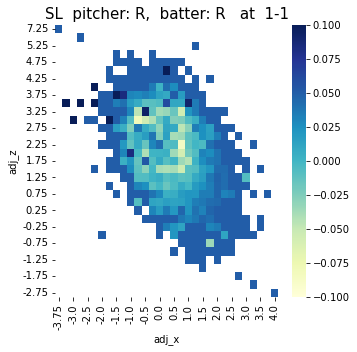

In [17]:
rr = sl_pv[(sl_pv['p_throws']=='R')&(sl_pv['stand']=='R')]
count00 =rr[rr['count']=='1-1']
test_pivot = count00.pivot_table(index='adj_z', columns='adj_x', values='pitch_value')
plt.figure(figsize=(5,5))
plt.title('SL  pitcher: R,  batter: R   at  1-1', size=15)
sns.heatmap(data=test_pivot.iloc[::-1],
            vmin=-0.1,
            vmax=0.1,
            cmap = 'YlGnBu')
plt.show()

In [18]:
pv_21 = pv[pv['game_year']==2021]
pitch_21 = pv_21[['player_name', 'pitch_name', 'p_throws', 'stand', 'count', 'adj_x', 'adj_z']]

In [19]:
pitch_list = ['4-Seam Fastball', 'Sinker', 'Cutter', 'Slider', 'Curveball', 'Changeup', 'Knuckle Curve', 'Split-Finger']

In [20]:
pitch_21

,player_name,pitch_name,p_throws,stand,count,adj_x,adj_z
193443,"Webb, Logan",Sinker,R,R,0-0,-1.25,2.25
988356,"Webb, Logan",Sinker,R,R,1-0,-0.25,2.50
735068,"Webb, Logan",Sinker,R,R,1-1,-0.25,2.00
1316590,"Webb, Logan",Changeup,R,R,1-2,0.75,0.50
1186612,"Webb, Logan",Changeup,R,R,2-2,-0.25,1.75
...,...,...,...,...,...,...,...
1059143,"Staumont, Josh",Curveball,R,R,1-0,0.75,2.50
806403,"Staumont, Josh",4-Seam Fastball,R,R,1-1,0.50,3.25
1384850,"Staumont, Josh",Curveball,R,R,1-2,1.50,1.50
1245294,"Staumont, Josh",Curveball,R,R,2-2,-1.00,4.50


In [21]:
pv

,game_year,player_name,pitch_name,p_throws,stand,count,plate_x,plate_z,pitch_value,adj_x,adj_z
242,2019,"Harvey, Matt",4-Seam Fastball,R,L,0-0,0.32,2.24,-0.044062,0.25,2.25
374871,2019,"Harvey, Matt",Slider,R,L,0-1,1.70,1.45,0.030520,1.75,1.50
659559,2019,"Harvey, Matt",4-Seam Fastball,R,L,1-1,0.91,2.36,0.050098,1.00,2.25
806443,2019,"Harvey, Matt",4-Seam Fastball,R,L,2-1,0.69,2.83,-0.072116,0.75,2.75
1124679,2019,"Harvey, Matt",Slider,R,L,2-2,2.10,0.48,0.379663,2.00,0.50
...,...,...,...,...,...,...,...,...,...,...,...
1059143,2021,"Staumont, Josh",Curveball,R,R,1-0,0.70,2.47,-0.051263,0.75,2.50
806403,2021,"Staumont, Josh",4-Seam Fastball,R,R,1-1,0.38,3.20,-0.064456,0.50,3.25
1384850,2021,"Staumont, Josh",Curveball,R,R,1-2,1.43,1.44,0.042439,1.50,1.50
1245294,2021,"Staumont, Josh",Curveball,R,R,2-2,-0.95,4.62,0.091271,-1.00,4.50


,player_name,pitch_value,count,grade
0,"Abad, Fernando",-0.000973,299,50
1,"Abbott, Cory",0.003301,352,45
2,"Abreu, Albert",0.005126,642,45
3,"Abreu, Bryan",0.007530,689,40
4,"Acevedo, Domingo",-0.002500,174,55
...,...,...,...,...
902,"Zimmermann, Bruce",-0.002785,1103,55
904,"Zuber, Tyler",0.000413,506,50
905,"de Geus, Brett",0.005152,909,45
906,"deGrom, Jacob",-0.005117,1226,65


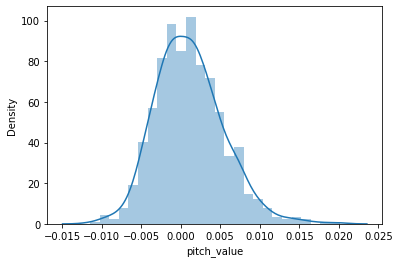

In [22]:
overall_pv = pv.groupby(['pitch_name', 'p_throws', 'stand', 'count', 'adj_x', 'adj_z'])['pitch_value'].mean().reset_index()
overall = pd.merge(pitch_21, overall_pv, on=['pitch_name', 'p_throws', 'stand', 'count', 'adj_x', 'adj_z'])
overall_total = overall.groupby(['player_name']).agg({'pitch_value': 'mean', 'pitch_name': 'count'}).reset_index().rename(columns={'pitch_name': 'count'})

overall_total_100 = overall_total[overall_total['count']>=100]
sns.distplot(overall_total_100['pitch_value'])

s_80 = overall_total_100['pitch_value'].quantile(q=0.001)
s_75 = overall_total_100['pitch_value'].quantile(q=0.006)
s_70 = overall_total_100['pitch_value'].quantile(q=0.022)
s_65 = overall_total_100['pitch_value'].quantile(q=0.067)
s_60 = overall_total_100['pitch_value'].quantile(q=0.158)
s_55 = overall_total_100['pitch_value'].quantile(q=0.308)
s_45 = overall_total_100['pitch_value'].quantile(q=0.692)
s_40 = overall_total_100['pitch_value'].quantile(q=0.842)
s_30 = overall_total_100['pitch_value'].quantile(q=0.978)
s_20 = overall_total_100['pitch_value'].quantile(q=0.999)

overall_total_100['grade'] = np.where(overall_total_100['pitch_value']>=s_20, 20, 0)
overall_total_100['grade'] = np.where(overall_total_100['pitch_value']<s_20, 30, overall_total_100['grade'])
overall_total_100['grade'] = np.where(overall_total_100['pitch_value']<s_30, 40, overall_total_100['grade'])
overall_total_100['grade'] = np.where(overall_total_100['pitch_value']<s_40, 45, overall_total_100['grade'])
overall_total_100['grade'] = np.where(overall_total_100['pitch_value']<s_45, 50, overall_total_100['grade'])
overall_total_100['grade'] = np.where(overall_total_100['pitch_value']<=s_55, 55, overall_total_100['grade'])
overall_total_100['grade'] = np.where(overall_total_100['pitch_value']<=s_60, 60, overall_total_100['grade'])
overall_total_100['grade'] = np.where(overall_total_100['pitch_value']<=s_65, 65, overall_total_100['grade'])
overall_total_100['grade'] = np.where(overall_total_100['pitch_value']<=s_70, 70, overall_total_100['grade'])
overall_total_100['grade'] = np.where(overall_total_100['pitch_value']<=s_75, 75, overall_total_100['grade'])
overall_total_100['grade'] = np.where(overall_total_100['pitch_value']<s_80, 80, overall_total_100['grade'])

overall_total_100

In [23]:
pitcher_list = np.array(pitch_21['player_name'].unique())
pitcher_command = pd.DataFrame(pitcher_list, columns=['player_name'])
for i in pitch_list:
    p = pv[pv['pitch_name']==i]
    p_pv = p.groupby(['p_throws', 'stand', 'count', 'adj_x', 'adj_z'])['pitch_value'].mean().reset_index()
    
    p_21 = pitch_21[pitch_21['pitch_name']==i]
    pitcher_21 = pd.merge(p_21, p_pv, on=['p_throws', 'stand', 'count', 'adj_x', 'adj_z'])
    
    command = pitcher_21.groupby(['player_name']).agg({'pitch_value': 'mean', 'p_throws': 'count'}).reset_index().rename(columns={'p_throws': 'count'})
    command_100 = command[command['count']>50]
    
    s_80 = command_100['pitch_value'].quantile(q=0.001)
    s_75 = command_100['pitch_value'].quantile(q=0.006)
    s_70 = command_100['pitch_value'].quantile(q=0.022)
    s_65 = command_100['pitch_value'].quantile(q=0.067)
    s_60 = command_100['pitch_value'].quantile(q=0.158)
    s_55 = command_100['pitch_value'].quantile(q=0.308)
    s_45 = command_100['pitch_value'].quantile(q=0.692)
    s_40 = command_100['pitch_value'].quantile(q=0.842)
    s_30 = command_100['pitch_value'].quantile(q=0.978)
    s_20 = command_100['pitch_value'].quantile(q=0.999)
    
    command_100['grade'] = np.where(command_100['pitch_value']>=s_20, 20, 0)
    command_100['grade'] = np.where(command_100['pitch_value']<s_20, 30, command_100['grade'])
    command_100['grade'] = np.where(command_100['pitch_value']<s_30, 40, command_100['grade'])
    command_100['grade'] = np.where(command_100['pitch_value']<s_40, 45, command_100['grade'])
    command_100['grade'] = np.where(command_100['pitch_value']<s_45, 50, command_100['grade'])
    command_100['grade'] = np.where(command_100['pitch_value']<=s_55, 55, command_100['grade'])
    command_100['grade'] = np.where(command_100['pitch_value']<=s_60, 60, command_100['grade'])
    command_100['grade'] = np.where(command_100['pitch_value']<=s_65, 65, command_100['grade'])
    command_100['grade'] = np.where(command_100['pitch_value']<=s_70, 70, command_100['grade'])
    command_100['grade'] = np.where(command_100['pitch_value']<=s_75, 75, command_100['grade'])
    command_100['grade'] = np.where(command_100['pitch_value']<s_80, 80, command_100['grade'])
    
    df = command_100[['player_name', 'grade']].rename(columns={'grade': i})
    pitcher_command = pd.merge(pitcher_command, df, on='player_name', how='left')

In [24]:
command_21 = pitcher_command.dropna(subset=['4-Seam Fastball', 'Sinker', 'Cutter', 'Slider', 'Curveball', 'Changeup', 'Knuckle Curve', 'Split-Finger'], axis=0, how='all')
command_21 = command_21.fillna(0)
command_21[['4-Seam Fastball', 'Sinker', 'Cutter', 'Slider', 'Curveball', 'Changeup', 'Knuckle Curve', 'Split-Finger']] = command_21[['4-Seam Fastball', 'Sinker', 'Cutter', 'Slider', 'Curveball', 'Changeup', 'Knuckle Curve', 'Split-Finger']].astype('int')

In [25]:
overall_total_100 = overall_total_100.rename(columns={'grade': 'Overall'})
overall_command = pd.merge(command_21, overall_total_100[['player_name', 'Overall']], on=['player_name'])
overall_command

,player_name,4-Seam Fastball,Sinker,Cutter,Slider,Curveball,Changeup,Knuckle Curve,Split-Finger,Overall
0,"Webb, Logan",50,50,0,55,0,55,0,0,60
1,"González, Chi Chi",50,50,50,50,50,55,0,0,50
2,"Baragar, Caleb",45,0,0,45,0,0,0,0,45
3,"Bowden, Ben",50,0,0,30,0,50,0,0,45
4,"Almonte, Yency",45,0,0,40,0,40,0,0,40
...,...,...,...,...,...,...,...,...,...,...
715,"Devenski, Chris",0,0,0,0,0,40,0,0,40
716,"Newsome, Ljay",75,0,0,0,50,70,0,0,75
717,"Phelps, David",70,0,30,0,0,0,0,0,50
718,"May, Dustin",40,65,45,0,55,0,0,0,55


In [26]:
overall_command[overall_command['player_name']=='Kim, Kwang Hyun']

,player_name,4-Seam Fastball,Sinker,Cutter,Slider,Curveball,Changeup,Knuckle Curve,Split-Finger,Overall
428,"Kim, Kwang Hyun",45,0,0,50,50,45,0,0,50


In [27]:
overall_command[overall_command['player_name']=='Ryu, Hyun Jin']

,player_name,4-Seam Fastball,Sinker,Cutter,Slider,Curveball,Changeup,Knuckle Curve,Split-Finger,Overall
317,"Ryu, Hyun Jin",65,0,55,0,55,60,0,0,65
